In [1]:
import pandas as pd
import numpy as np
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from matplotlib import dates
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [2]:
data = pd.read_csv('Data/book2.csv', parse_dates=['date'], index_col='date', header=0)
data.head()

,value
date,
2019-09-30,5357
2019-08-31,5882
2019-07-31,5922
2019-06-30,5446
2019-05-31,4900


In [3]:
data.columns = data.columns.str.strip()

In [4]:
data = data.reset_index()

In [5]:
# ADF Test
result = adfuller(data.value, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
#this data is non-stationary

ADF Statistic: 0.17213117285175186
n_lags: 0.9706544787206279
p-value: 0.9706544787206279
Critial Values:
   1%, -3.506944401824286
Critial Values:
   5%, -2.894989819214876
Critial Values:
   10%, -2.584614550619835


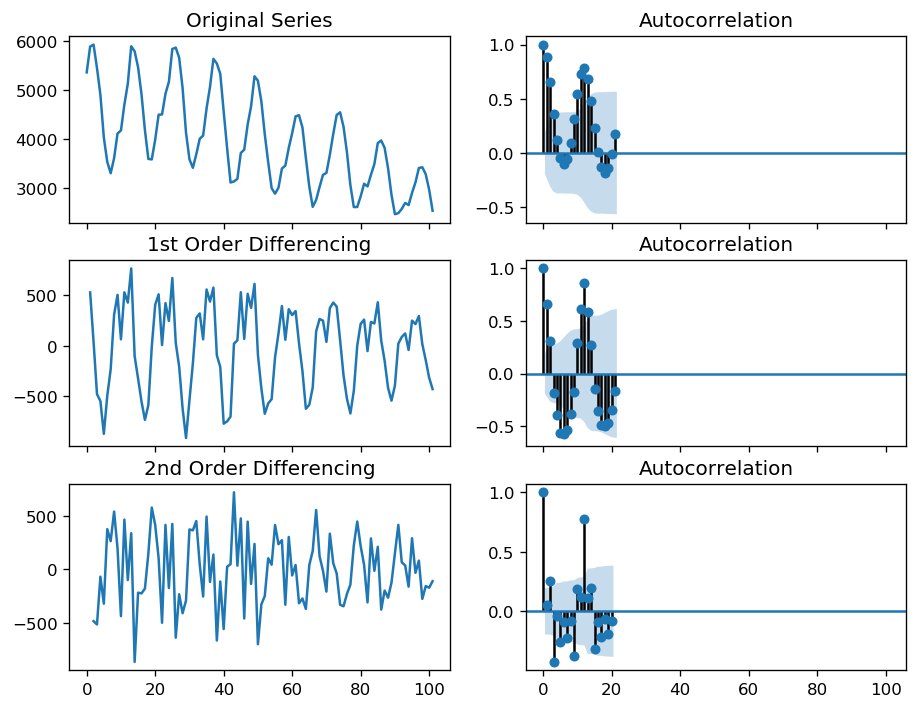

In [6]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data.value), (data.date); axes[0, 0].set_title('Original Series')
plot_acf(data.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

C:\Users\barbo\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1405: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


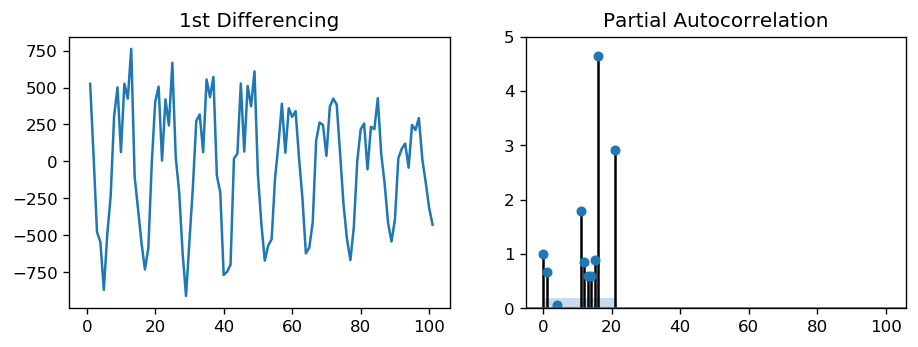

In [7]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.value.diff().dropna(), ax=axes[1])

plt.show()

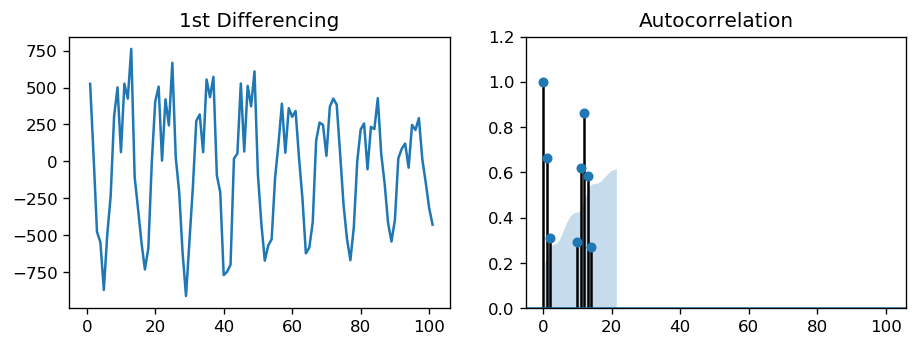

In [8]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.value.diff().dropna(), ax=axes[1])

plt.show()

In [9]:
from statsmodels.tsa.arima_model import ARIMA

# 2,1,2 ARIMA Model
model = ARIMA(data.value, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  101
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -680.471
Method:                       css-mle   S.D. of innovations            198.291
Date:                Thu, 09 Apr 2020   AIC                           1372.943
Time:                        19:22:58   BIC                           1388.633
Sample:                             1   HQIC                          1379.295
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -19.1033      8.520     -2.242      0.025     -35.802      -2.404
ar.L1.D.value     1.7170      0.014    122.502      0.000       1.689       1.744
ar.L2.D.value    -0.9852      0.013    -

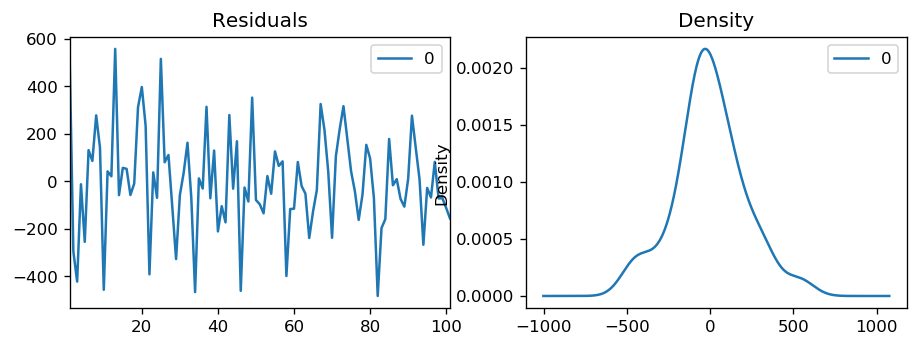

In [10]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

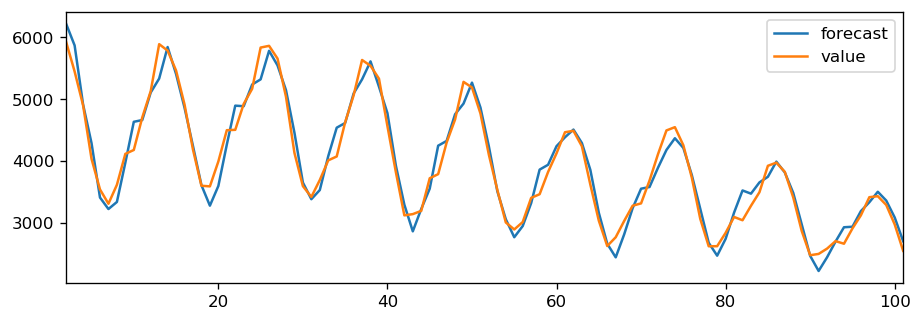

In [11]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [12]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = data.value[:80]
test = data.value[80:]

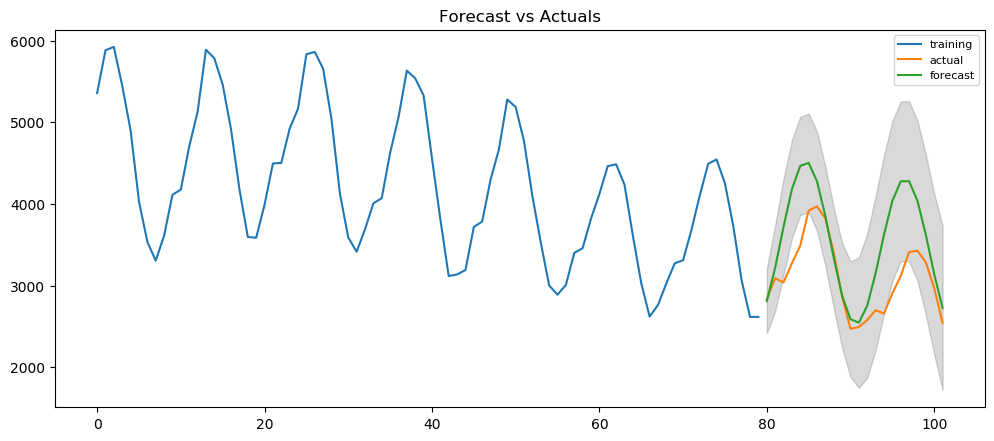

In [13]:
# Build Model
model = ARIMA(train, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(22, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper right', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   79
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -547.364
Method:                       css-mle   S.D. of innovations            238.820
Date:                Thu, 09 Apr 2020   AIC                           1104.728
Time:                        19:22:58   BIC                           1116.575
Sample:                             1   HQIC                          1109.475
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -18.6071      4.071     -4.570      0.000     -26.587     -10.627
ar.L1.D.value     1.5328      0.061     24.938      0.000       1.412       1.653
ar.L2.D.value    -0.8220      0.061    -

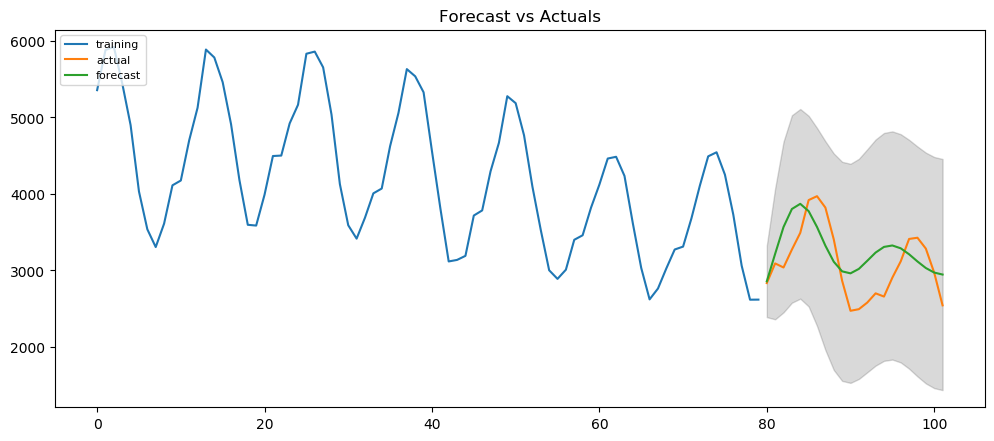

In [14]:
# Build Model
model = ARIMA(train, order=(2,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(22, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

C:\Users\barbo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'mape': 0.1153581116472868,
 'me': 152.22902317139167,
 'mae': 343.297594784768,
 'mpe': 0.0625576930923739,
 'rmse': 389.8119165629109,
 'acf1': 0.7382049282774567,
 'corr': 0.5924765258586093,
 'minmax': 0.10207638273665931}

In [16]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(data.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1480.282, BIC=1490.782, Time=0.142 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1692.474, BIC=1697.724, Time=0.005 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1519.943, BIC=1527.818, Time=0.013 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1593.903, BIC=1601.778, Time=0.079 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1987.714, BIC=1990.339, Time=0.005 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1437.262, BIC=1450.386, Time=0.049 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1435.252, BIC=1445.752, Time=0.066 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1437.255, BIC=1450.380, Time=0.058 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1433.139, BIC=1448.889, Time=0.236 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1392.189, BIC=1410.

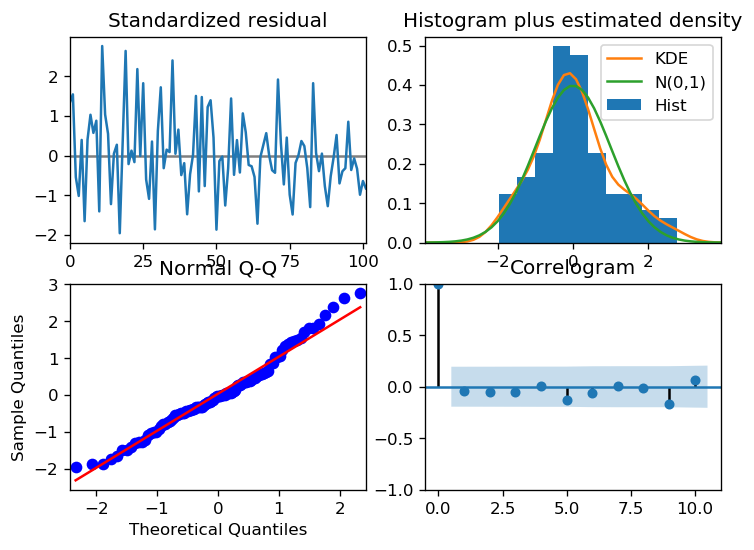

In [17]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

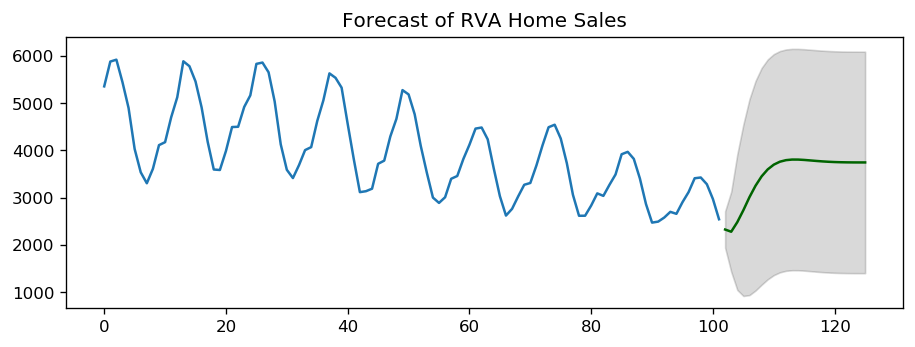

In [18]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(data.value), len(data.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Forecast of RVA Home Sales")
plt.show()

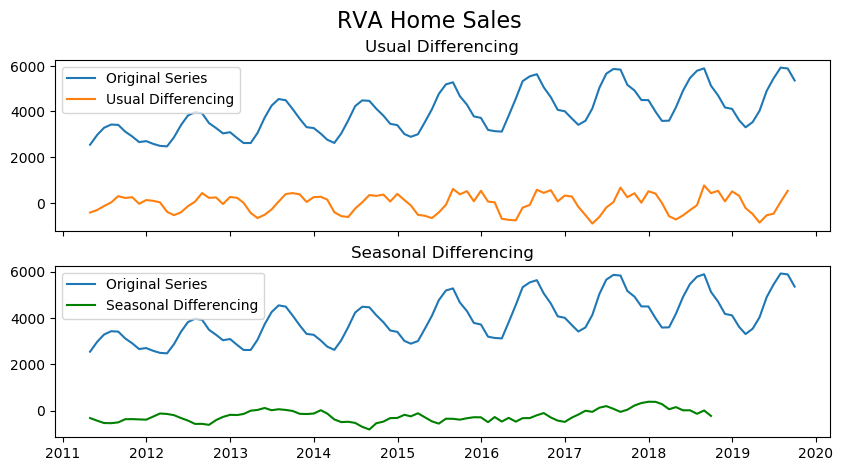

In [19]:
data = pd.read_csv('Data/book2.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('RVA Home Sales', fontsize=16)
plt.show()

In [20]:
data = pd.read_csv('Data/book2.csv', parse_dates=['date'], index_col='date')

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1109.551, BIC=1121.994, Time=0.715 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1114.421, BIC=1119.398, Time=0.010 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1107.908, BIC=1117.863, Time=0.446 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1108.097, BIC=1118.051, Time=0.385 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1112.427, BIC=1114.916, Time=0.010 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1116.419, BIC=1123.884, Time=0.081 seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 0, 12) (constant=True); AIC=1109.425, BIC=1121.868, Time=1.044 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1109.500, BIC=1121.943, Time=0.556 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1107.932, BIC=1117.887, Time=0.255 seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 1, 12) (constant=True); AIC=1111.322,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -550.239
Date:                              Thu, 09 Apr 2020   AIC                           1106.479
Time:                                      19:23:10   BIC                           1113.945
Sample:                                           0   HQIC                          1109.488
                                              - 102                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.5892      8.826     -0.180      0.857     -18.888      15.710
ma.S.L12      -0.3434      0.145     -2.373      0.018      -0.627      -0.060
sigma2      1.345e+04   2565.758      5.241      0.000    8417.076    1.85e+04
===================================================================================
Ljung-Box (Q):                       57.07   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.04   Prob(JB):                         0.35
Heteroskedasticity (H):               0.61   Skew:                            -0.04
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

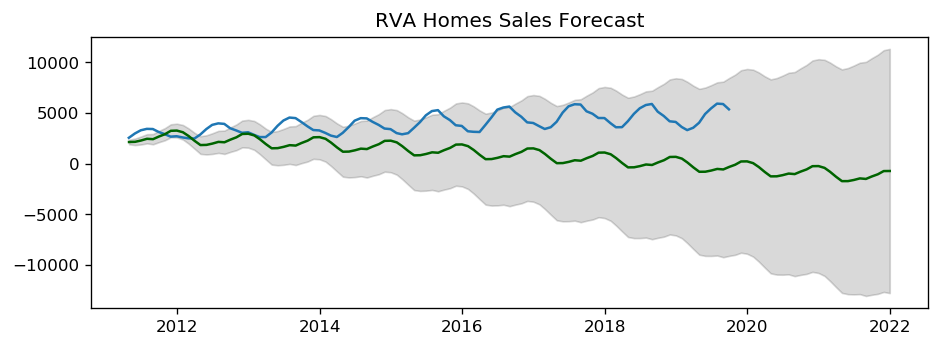

In [22]:
# Forecast
n_periods = 129
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("RVA Homes Sales Forecast")
plt.show()